In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/MyDrive /mydrive
%cd /mydrive/


Mounted at /content/gdrive
/content/gdrive/MyDrive


# Experiments
We'll go through learning feature embeddings using different loss functions on leopard  dataset. We are using 512-dimensional embeddings.

For every experiment Resnet18() is used currently no  hyperparameter search is implemented.

# Prepare dataset
We'll be working on leopard dataset

In [2]:
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import torch
transform_img = transforms.Compose([
    #transforms.Resize(size= (128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

In [3]:
%cd /mydrive/W210/Animal_Identification/siamese-triplet/

from datasets import LeopardDataset

MULTI_EMBEDDING = True
cuda = torch.cuda.is_available()

if MULTI_EMBEDDING:
    TRAIN_DATA_PATH = '../../../datasets/leopard/classes_64/resize_256/train'
    train_dataset = LeopardDataset(image_dir=TRAIN_DATA_PATH,transform=transform_img)
    TEST_DATA_PATH = '../../../datasets/leopard/classes_64/resize_256/test'
    test_dataset = LeopardDataset(image_dir=TEST_DATA_PATH,transform=transform_img)
    OOD_DATA_PATH = '../../../datasets/leopard/classes_64/ood_set'
    ood_dataset = LeopardDataset(image_dir=OOD_DATA_PATH,transform=transform_img)
else:
    TRAIN_DATA_PATH = '../../datasets/temp'
    train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_img)
    TEST_DATA_PATH = '../../datasets/temp'
    test_dataset = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_img)

/content/gdrive/MyDrive/W210/Animal_Identification/siamese-triplet


## Common setup

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [4]:
import numpy
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
from datasets import BalancedBatchSampler
import torch.nn as nn

    
train_labels = torch.tensor(train_dataset.targets)
test_labels = torch.tensor(test_dataset.targets)
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_labels, n_classes=64, n_samples=8)
test_batch_sampler = BalancedBatchSampler(test_labels, n_classes=64, n_samples=2)
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from networks import EmbeddingWithSoftmaxNet
from networks import MultiPartEmbeddingNet
from networks import MultiPartEmbeddingWithSoftmaxNet
from networks import extract_embeddings

from losses import OnlineTripletLoss
from losses import OnlineSymTripletLoss
from losses import OnlineModTripletLoss
from losses import OnlineTripletLossWithCentroid
from losses import OnlineModTripletLossWithCentroid

from utils_triplet import AllTripletSelector
from utils_triplet import HardestNegativeTripletSelector
from utils_triplet import RandomNegativeTripletSelector
from utils_triplet import SemihardNegativeTripletSelector
from utils_triplet import SemihardNegativeCentroidTripletSelector # Strategies for selecting triplets within a minibatch

from metrics import AverageNonzeroTripletsMetric
from sklearn.metrics import f1_score, classification_report 

margin = 0.35

try:
    model
    del model
except NameError:
    print('Model does not exist')

softmax = True
if MULTI_EMBEDDING:
    if softmax:
        embedding_net = EmbeddingWithSoftmaxNet(num_classes=64, dropout=0.2)
        #embedding_net = MultiPartEmbeddingWithSoftmaxNet(num_classes=64)
    else:
        embedding_net = MultiPartEmbeddingNet()
else:    
    if softmax:
        embedding_net = EmbeddingWithSoftmaxNet(num_classes=64)
    else:
        embedding_net = EmbeddingNet()
model = embedding_net

if cuda:
    model.cuda()
#loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
#loss_fn = OnlineSymTripletLoss(margin, RandomNegativeTripletSelector(margin))
#loss_fn = OnlineTripletLossWithCentroid(margin, SemihardNegativeCentroidTripletSelector(margin))
loss_fn = OnlineModTripletLossWithCentroid(margin, margin-0.2, SemihardNegativeCentroidTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 25
log_interval = 50
softmax_loss_fn = nn.CrossEntropyLoss()

Model does not exist


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
fit(online_train_loader, 
    online_test_loader, 
    model, loss_fn, 
    softmax_loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval, 
    metrics=[AverageNonzeroTripletsMetric()], 
    multi_class=MULTI_EMBEDDING,
    softmax=softmax)

Train: [0/853 (0%)]	Loss: 0.173127	Average nonzero triplets: 498.0
Model Saved
Epoch: 1/25. Train set: Average loss: 0.1731	Average nonzero triplets: 498.0
Epoch: 1/25. Validation set: Average loss: 0.2990	Average nonzero triplets: 106.0
Train: [0/853 (0%)]	Loss: 0.116694	Average nonzero triplets: 498.0
Epoch: 2/25. Train set: Average loss: 0.1167	Average nonzero triplets: 498.0
Epoch: 2/25. Validation set: Average loss: 0.2413	Average nonzero triplets: 106.0
Train: [0/853 (0%)]	Loss: 0.129912	Average nonzero triplets: 489.0
Epoch: 3/25. Train set: Average loss: 0.1299	Average nonzero triplets: 489.0
Epoch: 3/25. Validation set: Average loss: 0.2119	Average nonzero triplets: 106.0
Train: [0/853 (0%)]	Loss: 0.125698	Average nonzero triplets: 467.0
Epoch: 4/25. Train set: Average loss: 0.1257	Average nonzero triplets: 467.0
Epoch: 4/25. Validation set: Average loss: 0.1785	Average nonzero triplets: 106.0
Train: [0/853 (0%)]	Loss: 0.097372	Average nonzero triplets: 421.0
Epoch: 5/25. Trai

In [6]:
model_file_name = 'leop_id_model_july_24.pt'
path = f"/content/gdrive/MyDrive/W210/weights/{model_file_name}" 
#torch.save(model.state_dict(), path)

del model
model = embedding_net
model.load_state_dict(torch.load('./best_weights'))

<All keys matched successfully>

In [9]:
train_eval_loader = data.DataLoader(train_dataset, 
                                    batch_size=16, 
                                    shuffle=False,  
                                    num_workers=2, 
                                    drop_last=True, 
                                    pin_memory=cuda)

train_emb, train_softmax, train_ref_labels, train_pred_labels = extract_embeddings(train_eval_loader, 
                                                                                   model, 
                                                                                   multi_class=True, 
                                                                                   softmax=True,
                                                                                   cuda=cuda)
print(classification_report(train_pred_labels, train_ref_labels))

test_eval_loader = data.DataLoader(test_dataset, 
                                   batch_size=16, 
                                   shuffle=False,  
                                   num_workers=2, 
                                   drop_last=True, 
                                   pin_memory=cuda)

test_emb, test_softmax, test_ref_labels, test_pred_labels= extract_embeddings(test_eval_loader, 
                                                                              model,
                                                                              multi_class=True, 
                                                                              softmax=True,
                                                                              cuda=cuda)
                                                                              
print(classification_report(test_pred_labels, test_ref_labels))

ood_eval_loader = data.DataLoader(ood_dataset, 
                                  batch_size=1, 
                                  shuffle=False,  
                                  num_workers=2, 
                                  drop_last=True, 
                                  pin_memory=cuda)

ood_emb, ood_softmax, ood_ref_labels, ood_pred_labels= extract_embeddings(ood_eval_loader, 
                                                                          model,multi_class=True, 
                                                                          softmax=True,
                                                                          cuda=cuda)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8
           2       0.96      0.96      0.96        23
           3       0.96      1.00      0.98        27
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00        11
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00        14
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from utils_triplet import centdist
centroids = model.centroids.cuda()

train_emb_dist = centdist(train_emb, centroids)
train_emb_dist_sort, train_dist_indices = torch.sort(train_emb_dist, dim=1)
#print(classification_report(train_dist_indices[:,0].cpu().numpy(), train_ref_labels))
#print(sum(train_emb_dist_sort[:,0]<threshold)/train_emb_dist.size()[0])

test_emb_dist = centdist(test_emb, centroids)
test_emb_dist_ref = test_emb_dist[:, test_ref_labels] 
test_emb_dist_sort, test_dist_indices = torch.sort(test_emb_dist, dim=1)
#print(classification_report(test_dist_indices[:,0].cpu().numpy(), test_ref_labels))

test_softmax_sort, test_softmax_index = torch.sort(test_softmax, dim=1)
#print(sum(test_emb_dist[:,0]<threshold)/test_emb_dist.size()[0])

ood_emb_dist = centdist(ood_emb, centroids)
ood_emb_dist, ood_indices = torch.sort(ood_emb_dist, dim=1)

ood_softmax_sort, ood_softmax_index = torch.sort(ood_softmax, dim=1)
#print(sum(ood_emb_dist[:,0]>threshold)/ood_emb_dist.size()[0])

tensor(0.0312, device='cuda:0')
tensor(0.1810, device='cuda:0')


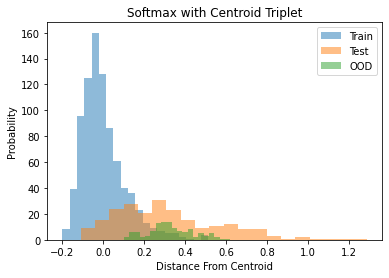

In [ ]:
test_emb_tensor_index = torch.tensor(test_ref_labels).cuda()
test_emb_dist_ref = test_emb_dist[range(test_emb_tensor_index.shape[0]), test_emb_tensor_index]
train_emb_tensor_index = torch.tensor(train_ref_labels).cuda()
train_emb_dist_ref = train_emb_dist[range(train_emb_tensor_index.shape[0]), train_emb_tensor_index]
train_emb_dist_mean = torch.mean(train_emb_dist_ref)
train_emb_dist_ref = train_emb_dist_ref - train_emb_dist_mean
test_emb_dist_ref = test_emb_dist_ref - train_emb_dist_mean

import matplotlib.pyplot as plt
bins = numpy.linspace(0, 0.2, 4)
plt.hist(train_emb_dist_ref.cpu().numpy(),  bins=20, alpha=0.5, label='Train')
plt.hist(test_emb_dist_ref.cpu().numpy(), bins=20, alpha=0.5, label='Test')

plt.hist((ood_emb_dist[:,0]-train_emb_dist_mean).cpu().numpy(), bins=20, alpha=0.5, label='OOD' )
#plt.title("Histogram of Distance from the centroid")
plt.title("Softmax with Centroid Triplet")
plt.xlabel('Distance From Centroid')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.show()


In [ ]:
threshold = 0.1
OOD_rejection_rate = 0.5

while sum(ood_emb_dist[:,0]<threshold)/ood_emb_dist.size()[0] < OOD_rejection_rate:
  threshold = threshold + 0.005

#test_emb, test_softmax, test_ref_labels, test_pred_labels= extract_embeddings(test_eval_loader, model,multi_class=True, softmax=True)
for i in range(len(test_pred_labels)):
    if test_emb_dist_sort[i,0] > threshold and test_val[i,-1] < 0.5 :
       test_pred_labels[i] = 100  
         
print(classification_report(test_pred_labels, test_ref_labels))
print(sum(ood_emb_dist[:,0]<threshold)/ood_emb_dist.size()[0], threshold)

tensor(0.5172, device='cuda:0') 0.6750000000000005


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_emb_cpu = train_emb.data.cpu().numpy()
test_emb_cpu = test_emb.data.cpu().numpy()
clf.fit(train_emb_cpu, train_ref_labels)

y_pred = clf.predict(train_emb_cpu)
train_acc = accuracy_score(train_ref_labels, y_pred)

y_pred = clf.predict(test_emb_cpu)
test_acc = accuracy_score(test_ref_labels, y_pred)

print("Training Accuracy: " + str(train_acc))
print("Testing Accuracy: " + str(test_acc))

Training Accuracy: 0.9964622641509434
Testing Accuracy: 0.5580357142857143
